#### Try to get better correlations with looking around a vehicle count measure station and take temperature measuring stations nearest to it instead of dividing basel in squares and looking for stations of both lying in them

In [6]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.animation import FuncAnimation
import matplotlib.patches as ptc
import os
import ast
import datetime as dt
import time
import geopy
from geopy import distance
import geopy.distance

import imageio
from scipy.interpolate import griddata
from scipy.interpolate import interp2d

import math

from functions import vals_to_boxes as boxes

In [30]:
temperature = pd.read_csv("datasets/luftklima_reformatted.csv")
vehicles = pd.read_csv("datasets/verkehrszählungen_reformatted.csv")
sdf = pd.read_csv("datasets/strassen.csv", delimiter=";")

In [8]:
box = [7.5554, 7.6240, 47.5342, 47.5815]
x_min = box[0]
x_max = box[1]
y_min = box[2]
y_max = box[3]

In [9]:
spoints = sdf["Geo Shape"]
start = spoints[0].find("[")
spoints = spoints.apply(lambda x: x[start:-1])

In [10]:
basel = plt.imread("maps/basel_square_bw.jpg")

In [11]:
# define function for plotting streets
def plot_streets(zorder=0, rainbow=False, color="red", alpha=1.0):
    label="speed limit ≥ 50km/h"
    for row in spoints:
        # from string to array
        lst = ast.literal_eval(row)
        npa = np.array(lst).T
        x = npa[0, :]
        y = npa[1, :]
        
        if rainbow:
            plt.plot(x, y, zorder=zorder, alpha=alpha, label=label)
            label=None
        else:
            plt.plot(x, y, zorder=zorder, c=color, alpha=alpha, label=label)
            label=None

In [12]:
def plot_stations(df, col_name, color="Blue", size=10, zorder=0, alpha=1, label="Measuring Stations", marker="o"):
    uni = df[col_name].unique()
    x = []
    y = []
    for point in uni:
        x.append(float(point.split(",")[1]))
        y.append(float(point.split(",")[0]))
    plt.scatter(x, y, label=label, c=color, s=size, zorder=zorder, alpha=alpha, marker=marker)

In [13]:
vehicles["Geo Point"].unique()

array(['47.5751385212,7.56315796773', '47.5707346457,7.58226721123',
       '47.5739067576,7.60221558365', '47.5747982039,7.56235975514',
       '47.544580317,7.58621009181', '47.5427356062,7.58499570186',
       '47.5952640302,7.65559694893', '47.5381329483,7.59973013355',
       '47.5451875415,7.6017439017', '47.5768609024,7.56734174237',
       '47.5454597631,7.59957932935', '47.5487720165,7.60074551669',
       '47.5665568071,7.59767325247', '47.5463002054,7.5956105688',
       '47.5741246781,7.57471395015', '47.5680940673,7.57380422434',
       '47.5676129884,7.57101717908', '47.5527116018,7.60459281521',
       '47.5582014188,7.59753472493', '47.5811860062,7.60450160902',
       '47.5699125893,7.57284015165', '47.5771259757,7.59655916981',
       '47.5656137668,7.58805266441', '47.5520832984,7.58677034361',
       '47.5889260115,7.5931162086', '47.5499027851,7.58292410405',
       '47.5441806077,7.57712039374', '47.5621767136,7.56405911184',
       '47.5722888439,7.6239861801', '

In [14]:
vec_stats = vehicles["Geo Point"].unique()
temp_stats = temperature["Koordinaten"].unique()

In [15]:
len(vec_stats), len(temp_stats)

(32, 181)

In [16]:
pd.set_option('display.max_columns', None)

In [40]:
vehicles.head()

,Unnamed: 0,SiteName,DateTimeFrom,DateTimeTo,Total,MR,PW,PW+,Lief,Lief+,Lief+Aufl.,LW,LW+,Sattelzug,Bus,andere,Year,Date,TimeFrom,TimeTo,Geo Point,Latitude,Longitude,hour,Datum
0,0,"235 A3-A35, Grenze CH-F",2019-01-01 00:00:00+01:00,2019-01-01 01:00:00+01:00,87,1,83,0,3,0,0,0,0,0,0,0,2019,01.01.2019,00:00,01:00,"47.5751385212,7.56315796773",47.575139,7.563158,0,2019-01-01
1,1,350 Dreirosenbrücke lokal,2019-01-01 00:00:00+01:00,2019-01-01 01:00:00+01:00,193,0,182,0,10,0,0,1,0,0,0,0,2019,01.01.2019,00:00,01:00,"47.5707346457,7.58226721123",47.570735,7.582267,0,2019-01-01
2,2,411 Fasanenstrasse,2019-01-01 00:00:00+01:00,2019-01-01 01:00:00+01:00,19,0,19,0,0,0,0,0,0,0,0,0,2019,01.01.2019,00:00,01:00,"47.5739067576,7.60221558365",47.573907,7.602216,0,2019-01-01
3,3,660 Flughafenstrasse,2019-01-01 00:00:00+01:00,2019-01-01 01:00:00+01:00,4,0,4,0,0,0,0,0,0,0,0,0,2019,01.01.2019,00:00,01:00,"47.5747982039,7.56235975514",47.574798,7.562360,0,2019-01-01
4,4,411 Fasanenstrasse,2019-01-01 00:00:00+01:00,2019-01-01 01:00:00+01:00,13,1,8,0,3,0,0,1,0,0,0,0,2019,01.01.2019,00:00,01:00,"47.5739067576,7.60221558365",47.573907,7.602216,0,2019-01-01


In [155]:
def get_temp_for_vstation(time_from, time_to, hour_from, radius, time_step = 1, half_day=False):
    startTime = time.time()
    
    date_and_hour_start = dt.datetime.strptime(time_from + " " + hour_from, "%Y-%m-%d %H")
    time_from = dt.datetime.strptime(time_from, "%Y-%m-%d")
    time_to = dt.datetime.strptime(time_to, "%Y-%m-%d")
    print(time_to)
    print(date_and_hour_start)
    print(time_to>date_and_hour_start)
    delta_days = (time_to - time_from).days
    
    vehicles["hour"] = pd.to_datetime(vehicles["TimeFrom"], format="%H:%M").dt.strftime("%H").astype(int)
    vehicles["Datum"] = pd.to_datetime(vehicles["Date"], format="%d.%m.%Y")#.dt.strftime("%Y-%m-%d")
    temperature["Datum"] = pd.to_datetime(temperature["Datum"], format="%Y-%m-%d")#.dt.strftime("%Y-%m-%d")
    temp = temperature[(temperature.Datum >= time_from) & (temperature.Datum <= time_to)]
    temp_here = temperature[(temperature.Datum >= time_from) & (temperature.Datum <= time_to)]
    veh = vehicles[(vehicles.Datum >= time_from) & (vehicles.Datum <= time_to)]
    veh_here = vehicles[(vehicles.Datum >= time_from) & (vehicles.Datum <= time_to)]
        
    veh_stats = veh["Geo Point"].unique()
    temp_stats = temp["Koordinaten"].unique()
    vx = []
    vy = []
    tx = []
    ty = []
    for point in veh_stats:
        vx.append(float(point.split(",")[1]))
        vy.append(float(point.split(",")[0]))
        
    for point in temp_stats:
        tx.append(float(point.split(",")[1]))
        ty.append(float(point.split(",")[0]))
        
    vn = len(veh_stats)
    tn = len(temp_stats)
    print(vn)
    print(tn)
    
    stats = [] # includes a set of nearby temp. measure stations for every vehicle count station
    
    for i in range(vn):
        stats_v = []
        for j in range(tn):
            if haversine(vx[i], vy[i], tx[j], ty[j]) < radius:
            #if math.sqrt((vx[i] - tx[j])**2 + (vy[i] - ty[j])**2) < radius:
                stats_v.append((tx[j], ty[j]))
        stats.append(stats_v)
        
    #print(stats)
    temp_here["Datum"] = pd.to_datetime(temp_here["Datum"], format="%Y-%m-%d").dt.strftime("%Y-%m-%d")
    veh_here["Datum"] = pd.to_datetime(veh_here["Datum"], format="%Y-%m-%d").dt.strftime("%Y-%m-%d")
    
    
    if half_day:
        corr = []
        v = 0
        for s in stats:
            date_start = date_and_hour_start
            corr_v = []
            corr_t = []
            while(True):
            #for i in range(delta_days):
                date = date_start.strftime("%Y-%m-%d")
                hour = int(date_start.strftime("%H"))

                hourly_stats_temp = temp_here[(temp_here.Datum == date) & (temp_here.Stunde == hour)]
                hourly_stats_veh = veh_here[(veh_here.Datum == date) & (veh_here.hour == hour)]
                #print(temp_here["Datum"].unique())
                temp = 0
                for stat in s:
                    #print(stat[0])
                    p = str(stat[1]) + "," + str(stat[0])
                    station = hourly_stats_temp[hourly_stats_temp["Koordinaten"] == p]
                    #print(station)
                    t = station["Lufttemperatur"].tolist()
                    #print(t.head())
                    if len(t) != 0:
                        #print(len(t))
                        temp += t[0]
                    else:
                        continue

                if len(s) > 0:
                    temp /= len(s)
                #print(temp, flush=True)

                p = str(vy[v]) + "," + str(vx[v])
                vc = hourly_stats_veh[hourly_stats_veh["Geo Point"] == p]
                vcs = vc["Total"].tolist()
                #print(len(vcs))
                if len(vcs) != 0:
                    v_num = 0
                    v_count = 0
                    for k in range(len(vcs)):
                        v_count += vcs[k]
                        v_num += 1
                    v_count /= v_num
                else:
                    continue
                    #v_count = 0
                #print(v_count)
                #print("HERE1")

                corr_v.append(v_count)
                corr_t.append(temp)


                #print(date, flush=True)
                date_start += dt.timedelta(hours=1)
                
                if int(date_start.strftime("%H")) > 18:
                    date_start += dt.timedelta(hours=14)
                    
                if date_start > time_to:
                    #print("DONE: " + str(v), flush=True)
                    break
                #print(date_start)

            corr_v = np.array(corr_v)        
            corr_t = np.array(corr_t)      
            c = np.corrcoef(np.vstack([corr_v, corr_t]))
            corr.append(c[0][1])

            v += 1  
            #print("DONE: " + str(v), flush=True)
            
    else:
        corr = []
        v = 0
        for s in stats:
            date_start = date_and_hour_start
            corr_v = []
            corr_t = []
            while(True):
            #for i in range(delta_days):
                date = date_start.strftime("%Y-%m-%d")
                hour = int(date_start.strftime("%H"))

                hourly_stats_temp = temp_here[(temp_here.Datum == date) & (temp_here.Stunde == hour)]
                hourly_stats_veh = veh_here[(veh_here.Datum == date) & (veh_here.hour == hour)]
                #print(temp_here["Datum"].unique())
                temp = 0
                for stat in s:
                    #print(stat[0])
                    p = str(stat[1]) + "," + str(stat[0])
                    station = hourly_stats_temp[hourly_stats_temp["Koordinaten"] == p]
                    #print(station)
                    t = station["Lufttemperatur"].tolist()
                    #print(t.head())
                    if len(t) != 0:
                        #print(len(t))
                        temp += t[0]
                    else:
                        continue

                if len(s) > 0:
                    temp /= len(s)
                #print(temp, flush=True)

                p = str(vy[v]) + "," + str(vx[v])
                vc = hourly_stats_veh[hourly_stats_veh["Geo Point"] == p]
                vcs = vc["Total"].tolist()
                print(vcs)
                if len(vcs) != 0:
                    v_num = 0
                    v_count = 0
                    for k in range(len(vcs)):
                        v_count += vcs[k]
                        v_num += 1
                    v_count /= v_num
                else:
                    continue
                    #v_count = 0
                #print(v_count)
                #print("HERE1")

                corr_v.append(v_count)
                corr_t.append(temp)
                
                print("Temp: " + str(temp) + " : " + str(v))
                print("v_count: " + str(v_count) + " : " + str(v))


                #print(date, flush=True)
                date_start += dt.timedelta(hours=time_step)
                if date_start > time_to:
                    #print("DONE: " + str(v), flush=True)
                    break

            corr_v = np.array(corr_v)        
            corr_t = np.array(corr_t)      
            c = np.corrcoef(np.vstack([corr_v, corr_t]))
            corr.append(c[0][1])

            v += 1  
            #print("DONE: " + str(v), flush=True)

    print(corr)
    print("TIME NEEDED: ", time.time() - startTime)
    return(vx, vy, corr)

In [156]:
def calc_ellipse_dists(x, y, dist):
    w = []
    h = []

    for i in range(len(x)):
        long2 = geopy.distance.distance(kilometers=dist).destination((y[i], x[i]), bearing=90)
        long2 = long2[1]
        lat2 = geopy.distance.distance(kilometers=dist).destination((y[i], x[i]), bearing=0)
        lat2 = lat2[0]
        
        width = 2 * (x[i] - long2)
        height = 2 * (y[i] - lat2)
        
        w.append(width)
        h.append(height)
        
    return(w, h) # width and height of ellipses

In [157]:
corr = get_temp_for_vstation("2020-06-01", "2020-06-03", "9",  0.4, 24)
el = calc_ellipse_dists(corr[0], corr[1], 0.4)

2020-06-03 00:00:00
2020-06-01 09:00:00
True
29
104
[[(7.62723, 47.56967)], [(7.587, 47.55095)], [(7.60161, 47.57565)], [(7.60123, 47.54891)], [(7.58357, 47.57244), (7.58329, 47.57121), (7.58341, 47.57367)], [(7.58355, 47.5411), (7.58117, 47.54391)], [], [], [(7.56166, 47.57182)], [], [(7.59473877546, 47.5670288104), (7.60092, 47.56705)], [], [(7.59349, 47.54443)], [(7.65389, 47.59263), (7.65379, 47.59267)], [(7.6033, 47.54355), (7.60302, 47.54431), (7.60326, 47.5428)], [(7.6033, 47.54355), (7.60302, 47.54431)], [(7.56166, 47.57182)], [], [(7.60092, 47.55702)], [], [(7.58883, 47.55483), (7.587, 47.55095)], [(7.57492, 47.57124)], [(7.56761, 47.56991)], [(7.58117, 47.54391)], [(7.57492, 47.57124), (7.57353, 47.57612)], [(7.57492, 47.57124), (7.56761, 47.56991)], [(7.6091, 47.55199)], [(7.57394, 47.54426), (7.58117, 47.54391)], [(7.5607, 47.56172)]]
[210, 77]
Temp: 16.905 : 0
v_count: 143.5 : 0
[176, 488]
Temp: 16.93 : 0
v_count: 332.0 : 0
[199, 56]
Temp: 16.005 : 1
v_count: 127.5 : 1
[42

C:\Users\phweb\AppData\Local\Temp/ipykernel_18748/3495191524.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_here["Datum"] = pd.to_datetime(temp_here["Datum"], format="%Y-%m-%d").dt.strftime("%Y-%m-%d")
C:\Users\phweb\AppData\Local\Temp/ipykernel_18748/3495191524.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veh_here["Datum"] = pd.to_datetime(veh_here["Datum"], format="%Y-%m-%d").dt.strftime("%Y-%m-%d")
C:\Users\phweb\Documents\miniconda3\envs\pr\lib\site-packages\numpy\lib\function_base.py

[36, 94, 43, 73, 114]
Temp: 17.015566666666665 : 4
v_count: 72.0 : 4
[266, 110, 109, 359, 181]
Temp: 19.2889 : 4
v_count: 205.0 : 4
[35, 111]
Temp: 15.435 : 5
v_count: 73.0 : 5
[342, 60]
Temp: 16.27 : 5
v_count: 201.0 : 5
[34, 35]
Temp: 0 : 6
v_count: 34.5 : 6
[59, 46]
Temp: 0 : 6
v_count: 52.5 : 6
[14, 20]
Temp: 0 : 7
v_count: 17.0 : 7
[154, 133]
Temp: 0 : 7
v_count: 143.5 : 7
[17, 16]
Temp: 19.23 : 8
v_count: 16.5 : 8
[91, 50]
Temp: 21.665 : 8
v_count: 70.5 : 8
[212, 144]
Temp: 0 : 9
v_count: 178.0 : 9
[291, 427]
Temp: 0 : 9
v_count: 359.0 : 9
[70, 63]
Temp: 18.064999999999998 : 10
v_count: 66.5 : 10
[204, 239]
Temp: 18.88 : 10
v_count: 221.5 : 10
[121, 112]
Temp: 0 : 11
v_count: 116.5 : 11
[411, 355]
Temp: 0 : 11
v_count: 383.0 : 11
[87, 151, 285, 198]
Temp: 15.74 : 12
v_count: 180.25 : 12
[428, 818, 290, 564]
Temp: 15.7 : 12
v_count: 525.0 : 12
[36, 32]
Temp: 16.675 : 13
v_count: 34.0 : 13
[77, 95]
Temp: 17.075 : 13
v_count: 86.0 : 13
[201, 199, 325]
Temp: 16.9822 : 14
v_count: 241

In [149]:
a = np.array([[16.905], [16.93]])
b = np.array([[143.5],[332.0]])
np.hstack([a,b])
a.shape

(2, 1)

In [150]:
np.corrcoef(np.hstack([a,b]))

array([[1., 1.],
       [1., 1.]])

In [152]:
corr[2]

[1.0,
 1.0,
 0.9999999999999998,
 1.0,
 0.9999999999999999,
 1.0,
 nan,
 nan,
 0.9999999999999999,
 nan,
 1.0,
 nan,
 -1.0,
 1.0,
 1.0,
 0.9999999999999999,
 0.9999999999999999,
 nan,
 -1.0,
 nan,
 1.0,
 0.9999999999999998,
 0.9999999999999998,
 1.0,
 1.0,
 1.0,
 nan,
 1.0,
 1.0]

In [107]:
corr[0], corr[1]

([7.62857136599,
  7.58292410405,
  7.60221558365,
  7.60074551669,
  7.58226721123,
  7.58499570186,
  7.64377560544,
  7.56734174237,
  7.56235975514,
  7.63010594485,
  7.59767325247,
  7.58805266441,
  7.5956105688,
  7.65559694893,
  7.6017439017,
  7.59957932935,
  7.56315796773,
  7.5931162086,
  7.59753472493,
  7.60450160902,
  7.58677034361,
  7.57380422434,
  7.57101717908,
  7.58621009181,
  7.57471395015,
  7.57284015165,
  7.60459281521,
  7.57712039374,
  7.56405911184],
 [47.5704032206,
  47.5499027851,
  47.5739067576,
  47.5487720165,
  47.5707346457,
  47.5427356062,
  47.5920790511,
  47.5768609024,
  47.5747982039,
  47.5628059399,
  47.5665568071,
  47.5656137668,
  47.5463002054,
  47.5952640302,
  47.5451875415,
  47.5454597631,
  47.5751385212,
  47.5889260115,
  47.5582014188,
  47.5811860062,
  47.5520832984,
  47.5680940673,
  47.5676129884,
  47.544580317,
  47.5741246781,
  47.5699125893,
  47.5527116018,
  47.5441806077,
  47.5621767136])

In [154]:
vehicles[(vehicles.Datum == "2020-06-02") & (vehicles.hour == 9) & (vehicles.Latitude == 47.5739067576)].head()

,Unnamed: 0,SiteName,DateTimeFrom,DateTimeTo,Total,MR,PW,PW+,Lief,Lief+,Lief+Aufl.,LW,LW+,Sattelzug,Bus,andere,Year,Date,TimeFrom,TimeTo,Geo Point,Latitude,Longitude,hour,Datum
811865,811865,411 Fasanenstrasse,2020-06-02 10:00:00+02:00,2020-06-02 11:00:00+02:00,65,2,52,0,8,0,0,3,0,0,0,0,2020,02.06.2020,09:00,10:00,"47.5739067576,7.60221558365",47.573907,7.602216,9,2020-06-02
811867,811867,411 Fasanenstrasse,2020-06-02 10:00:00+02:00,2020-06-02 11:00:00+02:00,124,6,103,0,10,1,0,4,0,0,0,0,2020,02.06.2020,09:00,10:00,"47.5739067576,7.60221558365",47.573907,7.602216,9,2020-06-02
811888,811888,411 Fasanenstrasse,2020-06-02 10:00:00+02:00,2020-06-02 11:00:00+02:00,57,3,37,0,7,0,0,4,0,0,6,0,2020,02.06.2020,09:00,10:00,"47.5739067576,7.60221558365",47.573907,7.602216,9,2020-06-02
811890,811890,411 Fasanenstrasse,2020-06-02 10:00:00+02:00,2020-06-02 11:00:00+02:00,74,2,45,0,15,1,0,1,0,2,8,0,2020,02.06.2020,09:00,10:00,"47.5739067576,7.60221558365",47.573907,7.602216,9,2020-06-02


In [160]:
temperature[(temperature.Datum == "2020-06-02") & (temperature.Stunde == 9) & (temperature.Breitengrad == 47.56967)].head(30)

,Unnamed: 0,Station-ID,Name,Zeitstempel,Datum,Stunde,Minute,Koordinaten,Breitengrad,Längengrad,Lufttemperatur,Regen in 1 h,Regen in 24 h,Regen in 48 h
63202,63202,03409965,Bäumlihofstrasse,2020-06-02 09:42:20+02:00,2020-06-02,9,42,"47.56967,7.62723",47.56967,7.62723,16.93,0.0,0.0,0.0


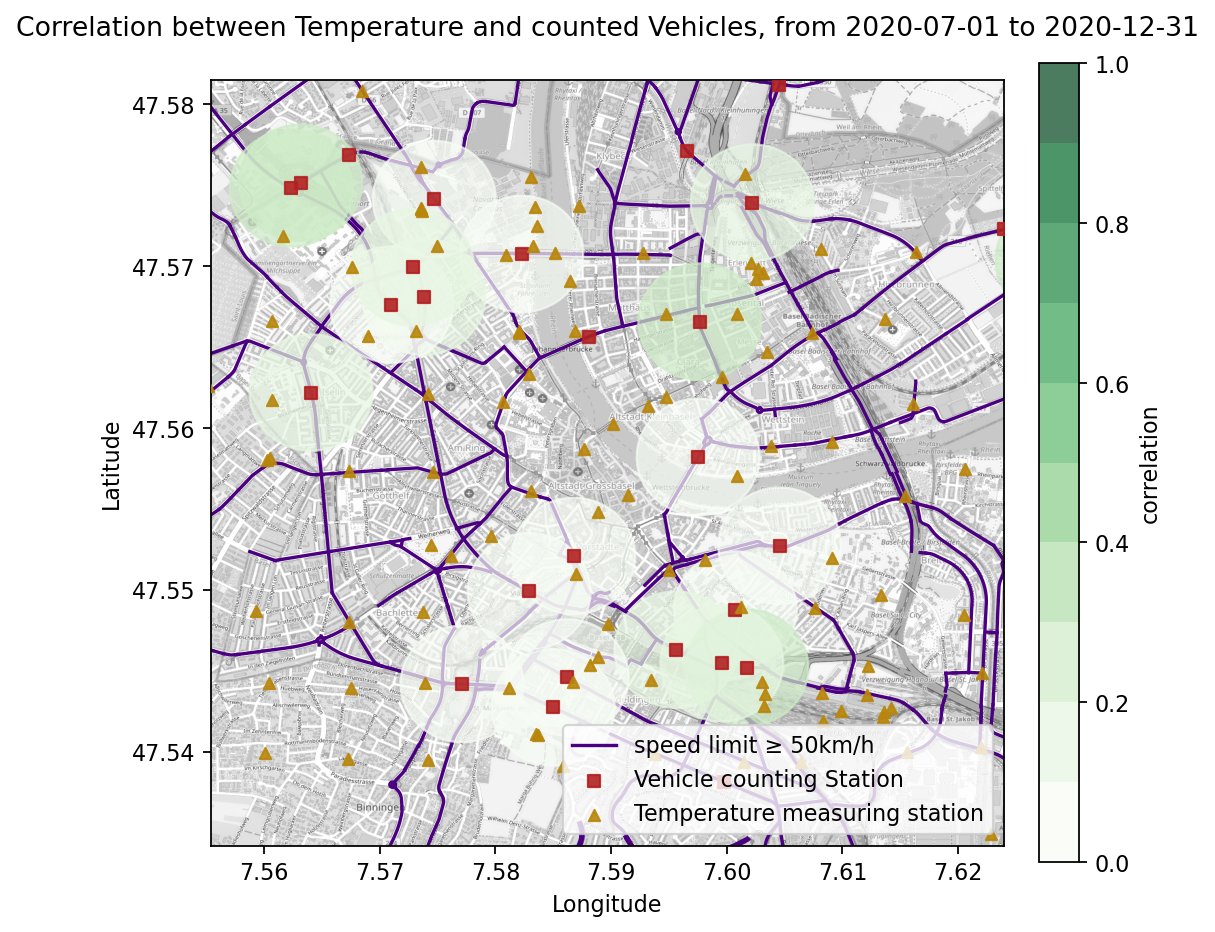

In [93]:
fig, ax = plt.subplots(figsize=(7, 7), dpi=160)
#plt.figure(figsize=(7, 7), dpi=160)

cmap = matplotlib.cm.get_cmap('Greens', 10)
norm = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0)
ellipses = []
for i in range(len(corr[2])):
    if corr[2][i] > -999999999999: #get rid of NaN
        ell = Ellipse((corr[0][i], corr[1][i]), el[0][i], el[1][i], 0, color=cmap(norm(corr[2][i])), fill = True, alpha=.7)
        #cir = plt.Circle((corr[0][i], corr[1][i]), 0.004, color=cmap(norm(corr[2][i])), fill = True, alpha=.7)
        ellipses.append(ell)
for e in ellipses:
     ax.add_artist(e)
        
plot_streets(zorder=1, color="indigo")        
plot_stations(vehicles, "Geo Point", zorder=3, size=25, color="firebrick", alpha=.9, label="Vehicle counting Station", marker=",")
plot_stations(temperature, "Koordinaten", zorder=3, size=25, color="darkgoldenrod", alpha=.9, label="Temperature measuring station", marker="^")
#plt.scatter(corr[0], corr[1], marker="o", zorder=1, c=corr[2], s=600)
plt.imshow(basel, extent=box, zorder=0, aspect=1.4, alpha=.7, cmap = matplotlib.cm.get_cmap('Greens', 10))
plt.colorbar(label="correlation", fraction=0.046, pad=0.04)
plt.clim((0, 1))
plt.title("Correlation between Temperature and counted Vehicles, from 2020-07-01 to 2020-12-31", pad=20)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='lower right')
plt.show()

img_name = "test_images/corr_try_1.png" 
fig.savefig(img_name)
plt.close()

In [74]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371*c
    return km

In [67]:
start = time.time()
for i in range(10000):
    haversine(7.59525,47.5535,7.59775,47.5565)
    #Wettsteinbrücke ca 370m here: 383m
print(time.time() - start)

start = time.time()
for i in range(10000):
    distance.distance((47.5535, 7.59525),(47.5565, 7.59775)).km
    #Wettsteinbrücke ca 370m here: 383m
print(time.time() - start)

print(haversine(7.59525,47.5535,7.59775,47.5565))
print(distance.distance((47.5535, 7.59525),(47.5565, 7.59775)).km)

0.018955469131469727
1.5738928318023682
0.38272159925913946
0.38295852972924904


In [77]:
p = geopy.distance.distance(kilometers=0.4).destination((47.56, 7.58), bearing=90)

In [82]:
p[0]

47.559999876851215

In [76]:
geopy.distance.distance(kilometers=0.4).destination((47.56, 7.58), bearing=0)

Point(47.56359771137424, 7.58, 0.0)

In [75]:
print(distance.distance((47.56, 7.58),(47.559999876851215, 7.585315071734571)).km)

0.39999999999996794


In [40]:
corr[0]

[7.62857136599,
 7.58292410405,
 7.60221558365,
 7.60074551669,
 7.58226721123,
 7.58499570186,
 7.64377560544,
 7.56734174237,
 7.56235975514,
 7.63010594485,
 7.59767325247,
 7.58805266441,
 7.5956105688,
 7.65559694893,
 7.6017439017,
 7.59957932935,
 7.56315796773,
 7.5931162086,
 7.59753472493,
 7.60450160902,
 7.58677034361,
 7.57380422434,
 7.57101717908,
 7.58621009181,
 7.57471395015,
 7.57284015165,
 7.60459281521,
 7.57712039374,
 7.56405911184]